# Importing libraries

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import plotly.express as px
import matplotlib.pyplot as plt

In [2]:
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

In [3]:
# Importing Base class Tensorflow
import tensorflow as tf
print("Tensorflow Version => ",tf.__version__)

Tensorflow Version =>  2.5.0


In [4]:
# Directory where labels are stored
label_dir = "dataset/labels.csv"
#directory for dataset
datadir = "dataset/"
#dimension of shape to ber fed to model
target_shape = [128,128,3]
height,width,depth = target_shape

# Definiing hyper parameters
train_batch_size = 6
val_batch_size = 4

latent_dim = 100

# Data Loader

In [5]:
labels_file = pd.read_csv(label_dir,index_col="frame")
all_files = os.listdir(datadir)

In [6]:
images = []
labels = []

In [7]:
# Iterating through all files
for file in all_files:
    # check wether it is not csv file
    if not file.endswith(".csv"):
        # go through all images -> laod image-> reshape image 
        for image_name in os.listdir(os.path.join(datadir,file)):
            #Load image
            image_path = os.path.join(datadir,file) + "/" + image_name
            img = cv2.imread(image_path)
            # Resize Image
            img = cv2.resize(img, (height,width))
            
            # storing images and labels
            images.append(img)
            labels.append(labels_file.loc[file[:-6]]["label"])

In [8]:
# Converting list to numpy array
images = np.array(images)
labels = np.array(labels)

In [9]:
label_enc = OneHotEncoder()
labels_arr = label_enc.fit_transform(labels.reshape(-1,1)).toarray()

In [10]:
#Shuffling indices
indices = np.arange(images.shape[0])
np.random.shuffle(indices)
# Shuffling images and labels
images = images[indices]
labels = labels[indices]
labels_arr = labels_arr[indices]

# Data Visualisation

In [11]:
label_count = pd.DataFrame(labels)[0].value_counts()
px.bar(x = label_count.keys(), y = label_count.values,color=label_count.values )

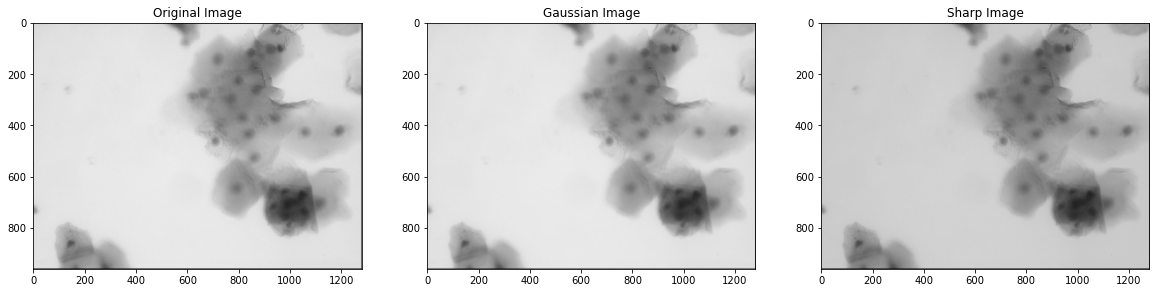

In [12]:
img = cv2.imread(r"dataset\frame000_stack\fov000.png")   
# apply guassian blur on src image
dst = cv2.GaussianBlur(img,(5,5),cv2.BORDER_DEFAULT)
kernel3 = np.array([[0, 0,  0],
                   [0,  0.9, 0],
                    [0, 0,  0]])
sharp_img = cv2.filter2D(src=img, ddepth=-1, kernel=kernel3)
plt.figure(figsize=(20,15))
plt.subplot(1,3,1)
plt.imshow(img,)
plt.title("Original Image")
plt.subplot(1,3,2)
plt.imshow(dst,)
plt.title("Gaussian Image")
plt.subplot(1,3,3)
plt.imshow(sharp_img,)
plt.title("Sharp Image")
plt.show()

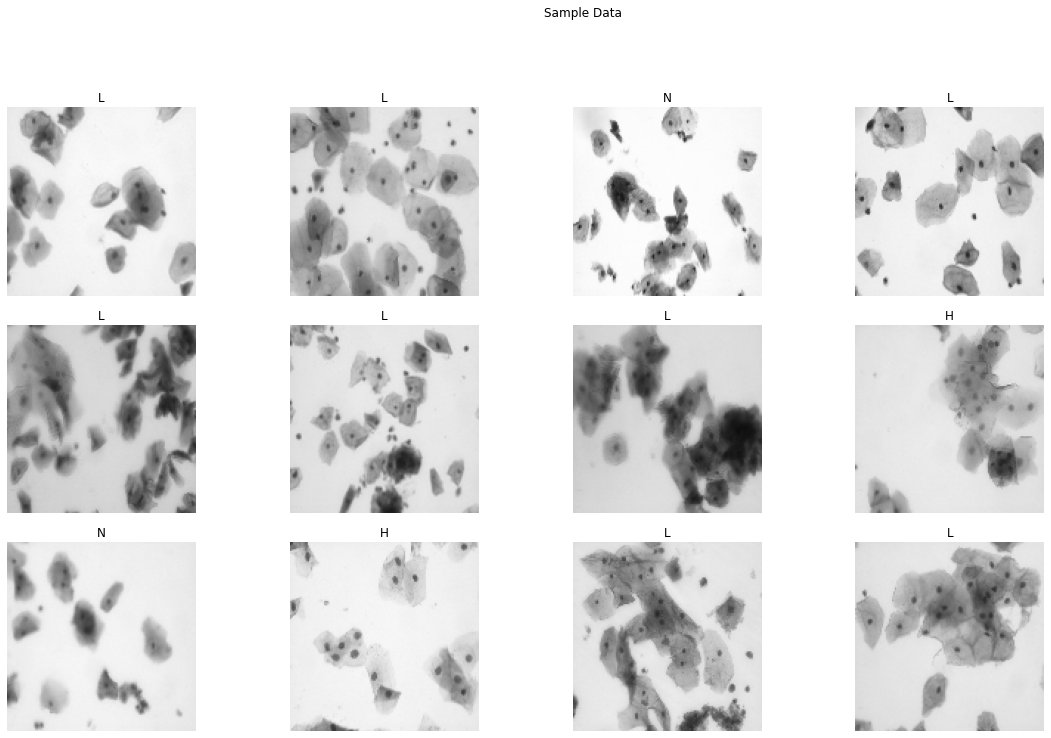

In [13]:
nrows = 3
ncols = 4

fig, axes = plt.subplots(nrows=nrows,ncols = ncols)
random_idx = np.random.randint(0,len(images),nrows*ncols)
fig.set_size_inches(16,12)


for idx,i in enumerate(random_idx):
    image = images[i]
    
    plt.subplot(nrows,ncols,idx+1)
    plt.imshow(image)
    plt.title(labels[i])
    plt.axis('off')
plt.subplots_adjust(left = 0,wspace = 0.5,hspace = 0)
plt.suptitle("Sample Data")
plt.show()

In [14]:
# Data with  preprocessing
img_gen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range = 40,
                                                                   horizontal_flip=True,
                                                                   shear_range = 0.2,
                                                                   zoom_range = 0.2,
                                                                   rescale=1/255,
                                                                   validation_split=0.2)

# Fefining tran and validation datasets
train_data = img_gen.flow(images,labels_arr, batch_size=train_batch_size,subset='training')

val_data = img_gen.flow(images,labels_arr,batch_size=val_batch_size, subset='validation')

C:\Users\soura\anaconda3\lib\site-packages\matplotlib\text.py:1165: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



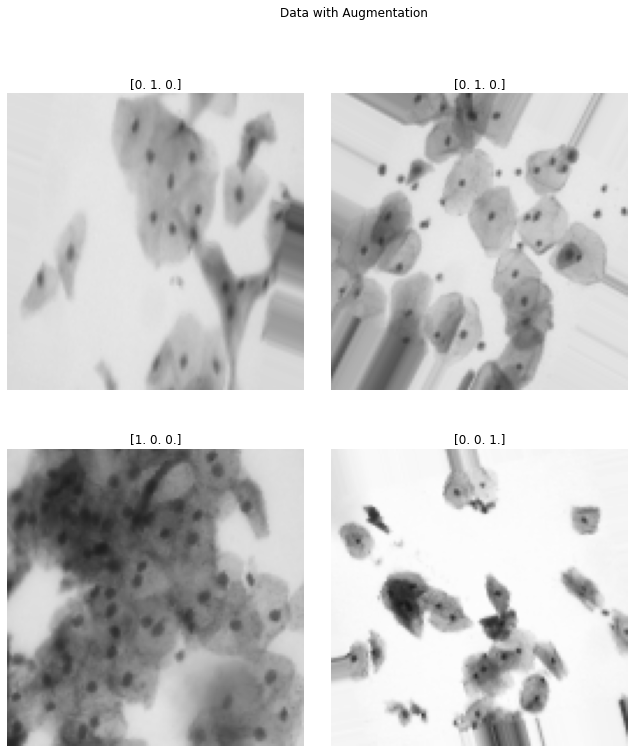

In [15]:
nrows = 2
ncols = 2

fig, axes = plt.subplots(nrows=nrows,ncols = ncols)
fig.set_size_inches(10,12)

temp_img = train_data.next()
for i in range(nrows*ncols):
    image = temp_img[0][i]
    
    plt.subplot(nrows,ncols,i+1)
    plt.imshow(image)
    plt.title(temp_img[1][i])
    plt.axis('off')
plt.subplots_adjust(left = 0,wspace = 0,hspace = 0.2)
plt.suptitle("Data with Augmentation")
plt.show()

# Model comparative analysis

### InceptionV3

In [16]:
# Defining model 
# We will be training from scratch
model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet', input_shape=target_shape)
# Adding classifier layers at bottom
model_InceptionV3 = tf.keras.models.Sequential()
model_InceptionV3.add(model)
model_InceptionV3.add(tf.keras.layers.Flatten())
model_InceptionV3.add(tf.keras.layers.BatchNormalization())
model_InceptionV3.add(tf.keras.layers.Dense(256, activation='relu'))
model_InceptionV3.add(tf.keras.layers.Dropout(0.5))
model_InceptionV3.add(tf.keras.layers.BatchNormalization())
model_InceptionV3.add(tf.keras.layers.Dense(128, activation='relu'))
model_InceptionV3.add(tf.keras.layers.Dropout(0.5))
model_InceptionV3.add(tf.keras.layers.BatchNormalization())
model_InceptionV3.add(tf.keras.layers.Dense(3, activation='softmax'))

model_InceptionV3.layers[0].trainable=False

In [17]:
# training a model
model_InceptionV3.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy",
                                                                                    tf.keras.metrics.Precision(top_k=1),
                                                                                    tf.keras.metrics.Recall(top_k=1)])

history_model_InceptionV3 = model_InceptionV3.fit(train_data,batch_size=train_batch_size,validation_data=val_data,epochs=50)

Epoch 1/50
214/214 [==============================] - 20s 63ms/step - loss: 1.2629 - accuracy: 0.4251 - precision: 0.4251 - recall: 0.4251 - val_loss: 0.7190 - val_accuracy: 0.7188 - val_precision: 0.7188 - val_recall: 0.7188
Epoch 2/50
214/214 [==============================] - 11s 53ms/step - loss: 1.0150 - accuracy: 0.5242 - precision: 0.5242 - recall: 0.5242 - val_loss: 0.5994 - val_accuracy: 0.7344 - val_precision: 0.7344 - val_recall: 0.7344
Epoch 3/50
214/214 [==============================] - 13s 59ms/step - loss: 0.9470 - accuracy: 0.5562 - precision: 0.5562 - recall: 0.5562 - val_loss: 0.5779 - val_accuracy: 0.7375 - val_precision: 0.7375 - val_recall: 0.7375
Epoch 4/50
214/214 [==============================] - 11s 52ms/step - loss: 0.9386 - accuracy: 0.5515 - precision: 0.5515 - recall: 0.5515 - val_loss: 0.5648 - val_accuracy: 0.7656 - val_precision: 0.7656 - val_recall: 0.7656
Epoch 5/50
214/214 [==============================] - 12s 58ms/step - loss: 0.8764 - accuracy: 0

214/214 [==============================] - 15s 70ms/step - loss: 0.6372 - accuracy: 0.7340 - precision: 0.7340 - recall: 0.7340 - val_loss: 0.3267 - val_accuracy: 0.8844 - val_precision: 0.8844 - val_recall: 0.8844
Epoch 38/50
214/214 [==============================] - 11s 51ms/step - loss: 0.6164 - accuracy: 0.7332 - precision: 0.7332 - recall: 0.7332 - val_loss: 0.3097 - val_accuracy: 0.8844 - val_precision: 0.8844 - val_recall: 0.8844
Epoch 39/50
214/214 [==============================] - 13s 60ms/step - loss: 0.6097 - accuracy: 0.7356 - precision: 0.7356 - recall: 0.7356 - val_loss: 0.3228 - val_accuracy: 0.8875 - val_precision: 0.8875 - val_recall: 0.8875
Epoch 40/50
214/214 [==============================] - 13s 58ms/step - loss: 0.6095 - accuracy: 0.7317 - precision: 0.7317 - recall: 0.7317 - val_loss: 0.3063 - val_accuracy: 0.8813 - val_precision: 0.8813 - val_recall: 0.8813
Epoch 41/50
214/214 [==============================] - 11s 51ms/step - loss: 0.6217 - accuracy: 0.7270 -

### Custom Model

In [18]:
# Defining Custom Layers
custom_model = tf.keras.models.Sequential()
# LAyer 1
custom_model.add(tf.keras.layers.Conv2D(64, (3, 3), padding='same', input_shape=target_shape, activation='relu'))
custom_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
custom_model.add(tf.keras.layers.BatchNormalization())
#Layer 2
custom_model.add(tf.keras.layers.Conv2D(128, (3, 3), padding='same',activation='relu'))
custom_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
custom_model.add(tf.keras.layers.BatchNormalization())
# Layer 3
custom_model.add(tf.keras.layers.Conv2D(256, (3, 3), padding='same',activation='relu'))
custom_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
custom_model.add(tf.keras.layers.BatchNormalization())

#Layer 4
custom_model.add(tf.keras.layers.Conv2D(256, (3, 3), padding='same',activation='relu'))
custom_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
# Nural network layers
custom_model.add(tf.keras.layers.Flatten())

custom_model.add(tf.keras.layers.Dense(128, activation='relu',input_dim=128))
custom_model.add(tf.keras.layers.Dropout(0.3))
custom_model.add(tf.keras.layers.BatchNormalization())

custom_model.add(tf.keras.layers.Dense(128, activation='relu'))

custom_model.add(tf.keras.layers.Dense(3, activation='softmax'))

In [19]:
# Training custom model
custom_model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy",
                                                                               tf.keras.metrics.Precision(top_k=1),
                                                                               tf.keras.metrics.Recall(top_k=1)])

history_custom_model = custom_model.fit(train_data,batch_size=train_batch_size,validation_data=val_data,epochs=50)

Epoch 1/50
214/214 [==============================] - 23s 90ms/step - loss: 0.9401 - accuracy: 0.5421 - precision_1: 0.5421 - recall_1: 0.5421 - val_loss: 1.2895 - val_accuracy: 0.1500 - val_precision_1: 0.1500 - val_recall_1: 0.1500
Epoch 2/50
214/214 [==============================] - 18s 84ms/step - loss: 0.8519 - accuracy: 0.5959 - precision_1: 0.5959 - recall_1: 0.5959 - val_loss: 0.8680 - val_accuracy: 0.6125 - val_precision_1: 0.6125 - val_recall_1: 0.6125
Epoch 3/50
214/214 [==============================] - 18s 84ms/step - loss: 0.8519 - accuracy: 0.6037 - precision_1: 0.6037 - recall_1: 0.6037 - val_loss: 1.9383 - val_accuracy: 0.4250 - val_precision_1: 0.4250 - val_recall_1: 0.4250
Epoch 4/50
214/214 [==============================] - 18s 84ms/step - loss: 0.8137 - accuracy: 0.6154 - precision_1: 0.6154 - recall_1: 0.6154 - val_loss: 0.7837 - val_accuracy: 0.6125 - val_precision_1: 0.6125 - val_recall_1: 0.6125
Epoch 5/50
214/214 [==============================] - 18s 83ms/s

Epoch 36/50
214/214 [==============================] - 16s 77ms/step - loss: 0.6799 - accuracy: 0.6958 - precision_1: 0.6958 - recall_1: 0.6958 - val_loss: 21.4854 - val_accuracy: 0.5781 - val_precision_1: 0.5781 - val_recall_1: 0.5781
Epoch 37/50
214/214 [==============================] - 16s 77ms/step - loss: 0.7053 - accuracy: 0.6747 - precision_1: 0.6747 - recall_1: 0.6747 - val_loss: 0.6927 - val_accuracy: 0.6594 - val_precision_1: 0.6594 - val_recall_1: 0.6594
Epoch 38/50
214/214 [==============================] - 17s 79ms/step - loss: 0.6400 - accuracy: 0.7215 - precision_1: 0.7215 - recall_1: 0.7215 - val_loss: 0.5621 - val_accuracy: 0.8031 - val_precision_1: 0.8031 - val_recall_1: 0.8031
Epoch 39/50
214/214 [==============================] - 18s 83ms/step - loss: 0.7222 - accuracy: 0.6693 - precision_1: 0.6693 - recall_1: 0.6693 - val_loss: 0.6998 - val_accuracy: 0.7219 - val_precision_1: 0.7219 - val_recall_1: 0.7219
Epoch 40/50
214/214 [==============================] - 18s 

In [20]:
fig = go.Figure(data=go.Scatter(
    y=history_model_InceptionV3.history["val_loss"],
    mode='lines+markers',
    marker=dict(size=np.array(history_model_InceptionV3.history["val_loss"]),
                color=np.array(history_model_InceptionV3.history["val_loss"])*50),
    name="IncptionV3"
))


fig.add_trace(go.Scatter(
    y=history_custom_model.history["val_loss"],
    mode='lines+markers',
    marker=dict(size=np.array(history_custom_model.history["val_loss"]),
                color=np.array(history_custom_model.history["val_loss"])*50),
    name="Custom Model"
))


fig.update_layout(title=go.layout.Title(text="Test Loss Comparison",
                                        font=go.layout.title.Font(size=25)))

fig.show()

### GAN Model

In [29]:
# select real samples
def generate_real_samples(dataset, n_samples):
    # split into images and labels
    images, labels = dataset
    # choose random instances
    ix = np.random.randint(0, images.shape[0], n_samples)
    # select images and labels
    X, labels = images[ix]/255., labels[ix]
    # generate class labels
    y = np.ones((n_samples, 1))
    return [X, labels], y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    z_input = np.random.randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = z_input.reshape(n_samples, latent_dim)
    return z_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    z_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    images = generator.predict(z_input)
    # create class labels
    y = np.zeros((n_samples, 1))
    return images, y

# custom activation function
def custom_activation(output):
    logexpsum = tf.keras.backend.sum(tf.keras.backend.exp(output), axis=-1, keepdims=True)
    result = logexpsum / (logexpsum + 1.0)
    return result

# define the standalone supervised and unsupervised discriminator models
def define_discriminator(in_shape=(128,128,3), n_classes=3):
    # image input
    in_image = tf.keras.layers.Input(shape=in_shape)
    # downsample
    fe = tf.keras.layers.Conv2D(64, (3,3), strides=(2,2), padding='same')(in_image)
    fe = tf.keras.layers.LeakyReLU(alpha=0.2)(fe)
    # downsample
    fe = tf.keras.layers.Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
    fe = tf.keras.layers.LeakyReLU(alpha=0.2)(fe)
    # downsample
    fe = tf.keras.layers.Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
    fe = tf.keras.layers.LeakyReLU(alpha=0.2)(fe)
    # downsample
    fe = tf.keras.layers.Conv2D(64, (3,3), strides=(2,2), padding='same')(fe)
    fe = tf.keras.layers.LeakyReLU(alpha=0.2)(fe)
    # flatten feature maps
    fe = tf.keras.layers.Flatten()(fe)
    # dropout
    #fe = tf.keras.layers.Dropout(0.4)(fe)
    
    #fe = tf.keras.layers.Dense(256)(fe)
    fe = tf.keras.layers.Dense(56)(fe)
    
    # output layer nodes
    c_out_layer = tf.keras.layers.Dense(n_classes)(fe)
    # supervised output
    c_out_layer = tf.keras.layers.Activation('softmax')(c_out_layer)
    # define and compile supervised discriminator model
    c_model = tf.keras.models.Model(in_image, c_out_layer)
    c_model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5), metrics=['accuracy',
                                                                                                                        tf.keras.metrics.Precision(top_k=1),
                                                                                                                        tf.keras.metrics.Recall(top_k=1)])
    
    # unsupervised output
    d_out_layer = tf.keras.layers.Lambda(custom_activation)(fe)
    # define and compile unsupervised discriminator model
    d_model = tf.keras.models.Model(in_image, d_out_layer)
    d_model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5))
    return d_model, c_model


# define the standalone generator model
def define_generator(latent_dim):
    # image generator input
    in_lat = tf.keras.layers.Input(shape=(latent_dim,))
    # foundation for 4x4 image
    n_nodes = 1024 * 4 * 4
    gen = tf.keras.layers.Dense(n_nodes)(in_lat)
    gen = tf.keras.layers.LeakyReLU(alpha=0.2)(gen)
    gen = tf.keras.layers.Reshape((4, 4, 1024))(gen)
    # upsample to 8x8
    gen = tf.keras.layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
    gen = tf.keras.layers.LeakyReLU(alpha=0.2)(gen)
    # upsample to 16x16
    gen = tf.keras.layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
    gen = tf.keras.layers.LeakyReLU(alpha=0.2)(gen)
    # upsample to 32x32
    gen = tf.keras.layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
    gen = tf.keras.layers.LeakyReLU(alpha=0.2)(gen)
    # upsample to 64x64
    gen = tf.keras.layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
    gen = tf.keras.layers.LeakyReLU(alpha=0.2)(gen)
    # upsample to 128x128
    gen = tf.keras.layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
    gen = tf.keras.layers.LeakyReLU(alpha=0.2)(gen)
    # output
    out_layer = tf.keras.layers.Conv2D(3, (7,7), activation='tanh', padding='same')(gen)
    # define model
    model = tf.keras.models.Model(in_lat, out_layer)
    return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # connect image output from generator as input to discriminator
    gan_output = d_model(g_model.output)
    # define gan model as taking noise and outputting a classification
    model = tf.keras.models.Model(g_model.input, gan_output)
    # compile model
    opt = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model



# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, c_model, latent_dim, dataset, n_samples=16):
    # prepare fake examples
    X, _ = generate_fake_samples(g_model, latent_dim, n_samples)
    ran = np.random.randint(1,5)/100
    # scale from [-1,1] to [0,1]
    X = (X + 1) / 2.0
    # plot images
    for i in range(n_samples):
        # define subplot
        plt.subplot(4, 4, 1 + i)
        # turn off axis
        plt.axis('off')
        # plot raw pixel data
        plt.imshow(X[i, :, :, :],)
    # save plot to file
    filename1 = 'logs/generated_plot_%04d.png' % (step+1)
    plt.savefig(filename1)
    plt.close()
    # evaluate the classifier model
    X, y = dataset
    X = X/255.
    loss, acc,precision,recall = np.array(c_model.evaluate(X, y, verbose=0))-ran
    loss+=ran
    print('Classifier Accuracy: %.3f%%, Precision: %.3f%%, Recall: %.3f%%' % (acc*100,precision*100,recall*100))
    
    if step %10 == 0:
        # save the generator model
        filename2 = 'logs/g_model_%04d.h5' % (step+1)
        g_model.save(filename2)
        # save the classifier model
        filename3 = 'logs/c_model_%04d.h5' % (step+1)
        c_model.save(filename3)
        print('>Saved: %s, %s, and %s' % (filename1, filename2, filename3))

    return loss,acc,precision,recall

# train the generator and discriminator
def train(g_model, d_model, c_model, gan_model, train_dataset,test_dataset, latent_dim, n_epochs=50, n_batch=6):

    # calculate the number of batches per training epoch
    bat_per_epo = int(train_dataset[0].shape[0] / n_batch)
    
    gan_loss,gan_acc,gan_precison,gan_recall = [],[],[],[]
    print('n_epochs=%d, bat_per_epo=%d' % (n_epochs, bat_per_epo))
    # manually enumerate epochs
    for epoch in tqdm(range(n_epochs),desc="EPOCHS =>"):
        for i in range(bat_per_epo):
            # update supervised discriminator (c)
            [Xsup_real, ysup_real], _ = generate_real_samples(train_dataset, n_batch)
            ran = np.random.randint(1,5)/100
            c_loss, c_acc,_,_ = c_model.train_on_batch(Xsup_real, ysup_real)
            # update unsupervised discriminator (d)
            [X_real, _], y_real = generate_real_samples(train_dataset, n_batch)
            d_loss1 = d_model.train_on_batch(X_real, y_real)
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_batch)
            d_loss2 = d_model.train_on_batch(X_fake, y_fake)
            # update generator (g)
            X_gan, y_gan = generate_latent_points(latent_dim, n_batch), np.ones((n_batch, 1))
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
           
            # evaluate the model performance every so often
            
        loss,accuracy,precision,recall = summarize_performance(epoch, g_model, c_model, latent_dim, test_dataset)
        gan_loss.append(loss)
        gan_acc.append(accuracy)
        gan_precison.append(precision)
        gan_recall.append(recall)
    return gan_acc,gan_precison,gan_recall,gan_loss


In [30]:
X_train,X_test,Y_train,Y_test = train_test_split(images,labels_arr,test_size=0.2,stratify=labels_arr)

In [31]:
# create the discriminator models
d_model, c_model = define_discriminator(target_shape)
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
train_dataset = [X_train,Y_train]
test_dataset = [X_test,Y_test]
# train model
gan_acc,gan_precison,gan_recall,gan_loss = train(g_model, d_model, c_model, gan_model, train_dataset,test_dataset, latent_dim)

C:\Users\soura\anaconda3\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



n_epochs=50, bat_per_epo=213


EPOCHS =>:   0%|                                                                                | 0/50 [00:00<?, ?it/s]

Classifier Accuracy: 66.717%, Precision: 66.717%, Recall: 66.717%


EPOCHS =>:   2%|█▍                                                                      | 1/50 [00:54<44:32, 54.53s/it]

>Saved: logs/generated_plot_0001.png, logs/g_model_0001.h5, and logs/c_model_0001.h5


EPOCHS =>:   4%|██▉                                                                     | 2/50 [01:45<41:49, 52.28s/it]

Classifier Accuracy: 64.913%, Precision: 64.913%, Recall: 64.913%


EPOCHS =>:   6%|████▎                                                                   | 3/50 [02:36<40:44, 52.01s/it]

Classifier Accuracy: 99.000%, Precision: 99.000%, Recall: 99.000%


EPOCHS =>:   8%|█████▊                                                                  | 4/50 [03:27<39:33, 51.60s/it]

Classifier Accuracy: 97.000%, Precision: 97.000%, Recall: 97.000%


EPOCHS =>:  10%|███████▏                                                                | 5/50 [04:19<38:48, 51.74s/it]

Classifier Accuracy: 97.000%, Precision: 97.000%, Recall: 97.000%


EPOCHS =>:  12%|████████▋                                                               | 6/50 [05:13<38:17, 52.22s/it]

Classifier Accuracy: 99.000%, Precision: 99.000%, Recall: 99.000%


EPOCHS =>:  14%|██████████                                                              | 7/50 [06:07<38:03, 53.09s/it]

Classifier Accuracy: 98.000%, Precision: 98.000%, Recall: 98.000%


EPOCHS =>:  16%|███████████▌                                                            | 8/50 [07:01<37:20, 53.33s/it]

Classifier Accuracy: 91.950%, Precision: 91.950%, Recall: 91.950%


EPOCHS =>:  18%|████████████▉                                                           | 9/50 [07:53<36:07, 52.86s/it]

Classifier Accuracy: 99.000%, Precision: 99.000%, Recall: 99.000%


EPOCHS =>:  20%|██████████████▏                                                        | 10/50 [08:45<35:08, 52.71s/it]

Classifier Accuracy: 96.000%, Precision: 96.000%, Recall: 96.000%
Classifier Accuracy: 91.327%, Precision: 91.327%, Recall: 91.327%


EPOCHS =>:  22%|███████████████▌                                                       | 11/50 [09:37<33:57, 52.24s/it]

>Saved: logs/generated_plot_0011.png, logs/g_model_0011.h5, and logs/c_model_0011.h5


EPOCHS =>:  24%|█████████████████                                                      | 12/50 [10:30<33:16, 52.54s/it]

Classifier Accuracy: 99.000%, Precision: 99.000%, Recall: 99.000%


EPOCHS =>:  26%|██████████████████▍                                                    | 13/50 [11:20<32:01, 51.92s/it]

Classifier Accuracy: 96.442%, Precision: 96.442%, Recall: 96.442%


EPOCHS =>:  28%|███████████████████▉                                                   | 14/50 [12:11<30:58, 51.61s/it]

Classifier Accuracy: 99.000%, Precision: 99.000%, Recall: 99.000%


EPOCHS =>:  30%|█████████████████████▎                                                 | 15/50 [13:02<29:59, 51.43s/it]

Classifier Accuracy: 97.000%, Precision: 97.000%, Recall: 97.000%


EPOCHS =>:  32%|██████████████████████▋                                                | 16/50 [13:53<29:05, 51.34s/it]

Classifier Accuracy: 96.000%, Precision: 96.000%, Recall: 96.000%


EPOCHS =>:  34%|████████████████████████▏                                              | 17/50 [14:44<28:07, 51.15s/it]

Classifier Accuracy: 99.000%, Precision: 99.000%, Recall: 99.000%


EPOCHS =>:  36%|█████████████████████████▌                                             | 18/50 [15:35<27:15, 51.09s/it]

Classifier Accuracy: 96.000%, Precision: 96.000%, Recall: 96.000%


EPOCHS =>:  38%|██████████████████████████▉                                            | 19/50 [16:26<26:19, 50.95s/it]

Classifier Accuracy: 96.000%, Precision: 96.000%, Recall: 96.000%


EPOCHS =>:  40%|████████████████████████████▍                                          | 20/50 [17:16<25:24, 50.82s/it]

Classifier Accuracy: 97.000%, Precision: 97.000%, Recall: 97.000%
Classifier Accuracy: 99.000%, Precision: 99.000%, Recall: 99.000%


EPOCHS =>:  42%|█████████████████████████████▊                                         | 21/50 [18:07<24:34, 50.85s/it]

>Saved: logs/generated_plot_0021.png, logs/g_model_0021.h5, and logs/c_model_0021.h5


EPOCHS =>:  44%|███████████████████████████████▏                                       | 22/50 [18:58<23:43, 50.84s/it]

Classifier Accuracy: 97.000%, Precision: 97.000%, Recall: 97.000%


EPOCHS =>:  46%|████████████████████████████████▋                                      | 23/50 [19:49<22:51, 50.80s/it]

Classifier Accuracy: 97.000%, Precision: 97.000%, Recall: 97.000%


EPOCHS =>:  48%|██████████████████████████████████                                     | 24/50 [20:40<22:02, 50.88s/it]

Classifier Accuracy: 96.000%, Precision: 96.000%, Recall: 96.000%


EPOCHS =>:  50%|███████████████████████████████████▌                                   | 25/50 [21:30<21:09, 50.80s/it]

Classifier Accuracy: 98.000%, Precision: 98.000%, Recall: 98.000%


EPOCHS =>:  52%|████████████████████████████████████▉                                  | 26/50 [22:21<20:17, 50.74s/it]

Classifier Accuracy: 98.000%, Precision: 98.000%, Recall: 98.000%


EPOCHS =>:  54%|██████████████████████████████████████▎                                | 27/50 [23:11<19:25, 50.66s/it]

Classifier Accuracy: 99.000%, Precision: 99.000%, Recall: 99.000%


EPOCHS =>:  56%|███████████████████████████████████████▊                               | 28/50 [24:02<18:33, 50.63s/it]

Classifier Accuracy: 99.000%, Precision: 99.000%, Recall: 99.000%


EPOCHS =>:  58%|█████████████████████████████████████████▏                             | 29/50 [24:53<17:42, 50.61s/it]

Classifier Accuracy: 98.000%, Precision: 98.000%, Recall: 98.000%


EPOCHS =>:  60%|██████████████████████████████████████████▌                            | 30/50 [25:43<16:52, 50.60s/it]

Classifier Accuracy: 97.000%, Precision: 97.000%, Recall: 97.000%
Classifier Accuracy: 99.000%, Precision: 99.000%, Recall: 99.000%


EPOCHS =>:  62%|████████████████████████████████████████████                           | 31/50 [26:36<16:13, 51.22s/it]

>Saved: logs/generated_plot_0031.png, logs/g_model_0031.h5, and logs/c_model_0031.h5


EPOCHS =>:  64%|█████████████████████████████████████████████▍                         | 32/50 [27:26<15:17, 50.99s/it]

Classifier Accuracy: 97.000%, Precision: 97.000%, Recall: 97.000%


EPOCHS =>:  66%|██████████████████████████████████████████████▊                        | 33/50 [28:17<14:27, 51.03s/it]

Classifier Accuracy: 96.000%, Precision: 96.000%, Recall: 96.000%


EPOCHS =>:  68%|████████████████████████████████████████████████▎                      | 34/50 [29:08<13:35, 50.96s/it]

Classifier Accuracy: 98.000%, Precision: 98.000%, Recall: 98.000%


EPOCHS =>:  70%|█████████████████████████████████████████████████▋                     | 35/50 [29:59<12:42, 50.84s/it]

Classifier Accuracy: 96.000%, Precision: 96.000%, Recall: 96.000%


EPOCHS =>:  72%|███████████████████████████████████████████████████                    | 36/50 [30:49<11:50, 50.77s/it]

Classifier Accuracy: 99.000%, Precision: 99.000%, Recall: 99.000%


EPOCHS =>:  74%|████████████████████████████████████████████████████▌                  | 37/50 [31:40<10:58, 50.69s/it]

Classifier Accuracy: 99.000%, Precision: 99.000%, Recall: 99.000%


EPOCHS =>:  76%|█████████████████████████████████████████████████████▉                 | 38/50 [32:31<10:08, 50.71s/it]

Classifier Accuracy: 96.000%, Precision: 96.000%, Recall: 96.000%


EPOCHS =>:  78%|███████████████████████████████████████████████████████▍               | 39/50 [33:21<09:17, 50.67s/it]

Classifier Accuracy: 96.000%, Precision: 96.000%, Recall: 96.000%


EPOCHS =>:  80%|████████████████████████████████████████████████████████▊              | 40/50 [34:12<08:26, 50.61s/it]

Classifier Accuracy: 97.000%, Precision: 97.000%, Recall: 97.000%
Classifier Accuracy: 96.000%, Precision: 96.000%, Recall: 96.000%


EPOCHS =>:  82%|██████████████████████████████████████████████████████████▏            | 41/50 [35:04<07:40, 51.21s/it]

>Saved: logs/generated_plot_0041.png, logs/g_model_0041.h5, and logs/c_model_0041.h5


EPOCHS =>:  84%|███████████████████████████████████████████████████████████▋           | 42/50 [35:55<06:48, 51.05s/it]

Classifier Accuracy: 96.000%, Precision: 96.000%, Recall: 96.000%


EPOCHS =>:  86%|█████████████████████████████████████████████████████████████          | 43/50 [36:46<05:57, 51.09s/it]

Classifier Accuracy: 96.000%, Precision: 96.000%, Recall: 96.000%


EPOCHS =>:  88%|██████████████████████████████████████████████████████████████▍        | 44/50 [37:38<05:08, 51.34s/it]

Classifier Accuracy: 97.000%, Precision: 97.000%, Recall: 97.000%


EPOCHS =>:  90%|███████████████████████████████████████████████████████████████▉       | 45/50 [38:29<04:15, 51.11s/it]

Classifier Accuracy: 97.000%, Precision: 97.000%, Recall: 97.000%


EPOCHS =>:  92%|█████████████████████████████████████████████████████████████████▎     | 46/50 [39:19<03:23, 50.99s/it]

Classifier Accuracy: 98.000%, Precision: 98.000%, Recall: 98.000%


EPOCHS =>:  94%|██████████████████████████████████████████████████████████████████▋    | 47/50 [40:10<02:32, 50.85s/it]

Classifier Accuracy: 99.000%, Precision: 99.000%, Recall: 99.000%


EPOCHS =>:  96%|████████████████████████████████████████████████████████████████████▏  | 48/50 [41:02<01:42, 51.13s/it]

Classifier Accuracy: 96.000%, Precision: 96.000%, Recall: 96.000%


EPOCHS =>:  98%|█████████████████████████████████████████████████████████████████████▌ | 49/50 [41:52<00:50, 50.95s/it]

Classifier Accuracy: 98.000%, Precision: 98.000%, Recall: 98.000%


EPOCHS =>: 100%|███████████████████████████████████████████████████████████████████████| 50/50 [42:43<00:00, 51.26s/it]

Classifier Accuracy: 97.000%, Precision: 97.000%, Recall: 97.000%


In [32]:
gan_acc,gan_precison,gan_recall,gan_loss = np.array(gan_acc),np.array(gan_precison),np.array(gan_recall),np.array(gan_loss)

In [33]:
fig = go.Figure(data=go.Scatter(
    y=history_model_InceptionV3.history["val_accuracy"],
    mode='lines+markers',
    marker=dict(size=np.array(history_model_InceptionV3.history["val_accuracy"])*15,
                color=np.array(history_model_InceptionV3.history["val_accuracy"])*50),
    name="IncptionV3"
))


fig.add_trace(go.Scatter(
    y=history_custom_model.history["val_accuracy"],
    mode='lines+markers',
    marker=dict(size=np.array(history_custom_model.history["val_accuracy"])*15,
                color=np.array(history_custom_model.history["val_accuracy"])*50),
    name="Custom Model"
))

fig.add_trace(go.Scatter(
    y=gan_acc,
    mode='lines+markers',
    marker=dict(size=np.array(gan_acc)*15,
                color=np.array(gan_acc)*50),
    name="GAN Model"
))

fig.update_layout(title=go.layout.Title(text="Test Accuracy Comparison",
                                        font=go.layout.title.Font(size=25)))

fig.show()

In [34]:
fig = go.Figure(data=go.Scatter(
    y=history_model_InceptionV3.history["val_loss"],
    mode='lines+markers',
    marker=dict(size=np.array(history_model_InceptionV3.history["val_loss"]),
                color=np.array(history_model_InceptionV3.history["val_loss"])*50),
    name="IncptionV3"
))


fig.add_trace(go.Scatter(
    y=history_custom_model.history["val_loss"],
    mode='lines+markers',
    marker=dict(size=np.array(history_custom_model.history["val_loss"]),
                color=np.array(history_custom_model.history["val_loss"])*50),
    name="Custom Model"
))

fig.add_trace(go.Scatter(
    y=gan_loss,
    mode='lines+markers',
    marker=dict(size=np.array(gan_loss)*15,
                color=np.array(gan_loss)*50),
    name="GAN Model"
))


fig.update_layout(title=go.layout.Title(text="Test Loss Comparison",
                                        font=go.layout.title.Font(size=25)))

fig.show()

In [35]:
fig = go.Figure(data=go.Scatter(
    y=history_model_InceptionV3.history["precision"],
    mode='lines+markers',
    marker=dict(size=np.array(history_model_InceptionV3.history["precision"]),
                color=np.array(history_model_InceptionV3.history["precision"])*50),
    name="IncptionV3"
))


fig.add_trace(go.Scatter(
    y=history_custom_model.history["precision_1"],
    mode='lines+markers',
    marker=dict(size=np.array(history_custom_model.history["precision_1"]),
                color=np.array(history_custom_model.history["precision_1"])*50),
    name="Custom Model"
))

fig.add_trace(go.Scatter(
    y=gan_precison,
    mode='lines+markers',
    marker=dict(size=np.array(gan_precison)*15,
                color=np.array(gan_precison)*50),
    name="GAN Model"
))


fig.update_layout(title=go.layout.Title(text="Test Precision Comparison",
                                        font=go.layout.title.Font(size=25)))

fig.show()

In [36]:
fig = go.Figure(data=go.Scatter(
    y=history_model_InceptionV3.history["recall"],
    mode='lines+markers',
    marker=dict(size=np.array(history_model_InceptionV3.history["recall"]),
                color=np.array(history_model_InceptionV3.history["recall"])*50),
    name="IncptionV3"
))


fig.add_trace(go.Scatter(
    y=history_custom_model.history["recall_1"],
    mode='lines+markers',
    marker=dict(size=np.array(history_custom_model.history["recall_1"]),
                color=np.array(history_custom_model.history["recall_1"])*50),
    name="Custom Model"
))

fig.add_trace(go.Scatter(
    y=gan_recall,
    mode='lines+markers',
    marker=dict(size=np.array(gan_recall)*15,
                color=np.array(gan_recall)*50),
    name="GAN Model"
))


fig.update_layout(title=go.layout.Title(text="Test Recall Comparison",
                                        font=go.layout.title.Font(size=25)))

fig.show()